In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

df = pd.read_csv("C:/Users/sesa777393/Desktop/tareas/PIA_MIN_DAT/Data Cleaning/dataset_clean.csv")

In [ ]:
df['date_created'] = pd.to_datetime(df['date_created'])
df.set_index('date_created', inplace=True)
df.sort_index(inplace=True)  

time_series_data = df['downloads'].resample('M').sum()  
time_series_data = time_series_data.dropna()  


C:\Users\sesa777393\AppData\Local\Temp\ipykernel_38604\676401816.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_series_data = df['downloads'].resample('M').sum()  # Aggregate downloads by month


In [ ]:
def create_lagged_features(data, lags=1):
    """
    Creates lagged features for a time series.

    Args:
        data (pd.Series): Time series data.
        lags (int, optional): Number of lagged values to create. Defaults to 1.

    Returns:
        pd.DataFrame: DataFrame with lagged features.
    """
    df = pd.DataFrame(data)
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df['downloads'].shift(i)
    df.dropna(inplace=True) 
    return df

lagged_data = create_lagged_features(time_series_data, lags=3)  
print(lagged_data.head())

              downloads     lag_1     lag_2    lag_3
date_created                                        
2015-11-30          0.0       0.0   31377.0   3538.0
2015-12-31      59985.0       0.0       0.0  31377.0
2016-01-31     410939.0   59985.0       0.0      0.0
2016-02-29      24482.0  410939.0   59985.0      0.0
2016-03-31     112451.0   24482.0  410939.0  59985.0


In [ ]:
X = lagged_data.drop('downloads', axis=1)  
y = lagged_data['downloads']  

In [5]:
train_size = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]


In [ ]:
X_train = sm.add_constant(X_train)  
model = sm.OLS(y_train, X_train).fit()
print(model.summary())  


                            OLS Regression Results                            
Dep. Variable:              downloads   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     4.275
Date:                Fri, 16 May 2025   Prob (F-statistic):            0.00960
Time:                        12:29:20   Log-Likelihood:                -665.46
No. Observations:                  50   AIC:                             1339.
Df Residuals:                      46   BIC:                             1347.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.396e+04      4e+04      2.099      0.0

In [7]:
X_test = sm.add_constant(X_test)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


In [8]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"\nTrain MSE: {train_mse}")
print(f"Test MSE: {test_mse}")


Train MSE: 21272643208.537865
Test MSE: 17118099700.58269


In [ ]:
forecast_steps = 3
forecast = []
last_window = np.array(X_test[-1:].values).flatten().tolist()  

for _ in range(forecast_steps):
    next_pred = model.predict(sm.add_constant(np.array(last_window).reshape(1, -1)))[0]
    forecast.append(next_pred)
    last_window.pop(0)
    last_window.append(next_pred)

print("\n--- Forecast ---")
print(forecast)


--- Forecast ---
[np.float64(106116.57177911294), np.float64(2051781694.545904), np.float64(4412311418.527398)]


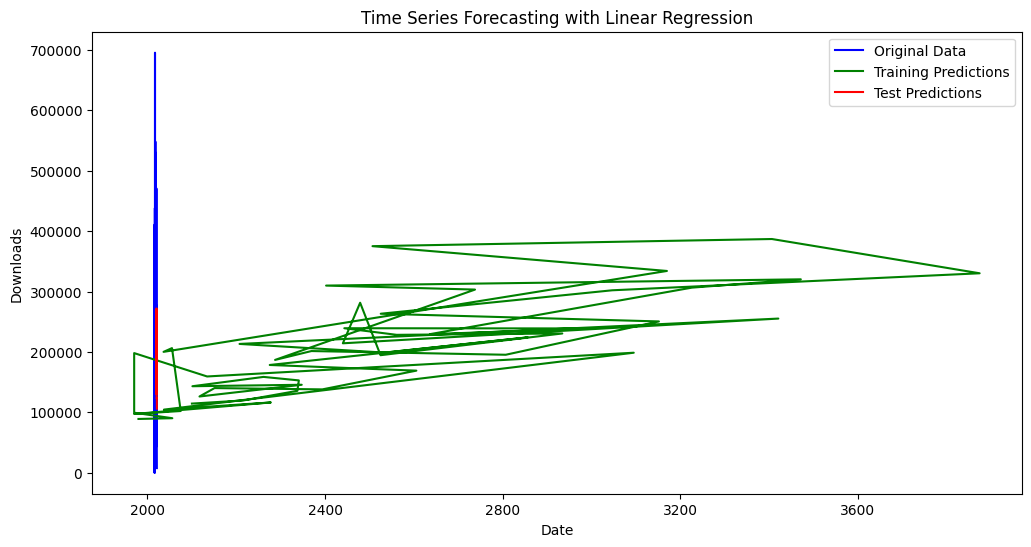

C:\Users\sesa777393\AppData\Local\Temp\ipykernel_38604\634509761.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=time_series_data.index[-1], periods=forecast_steps + 1, freq='M')[1:]


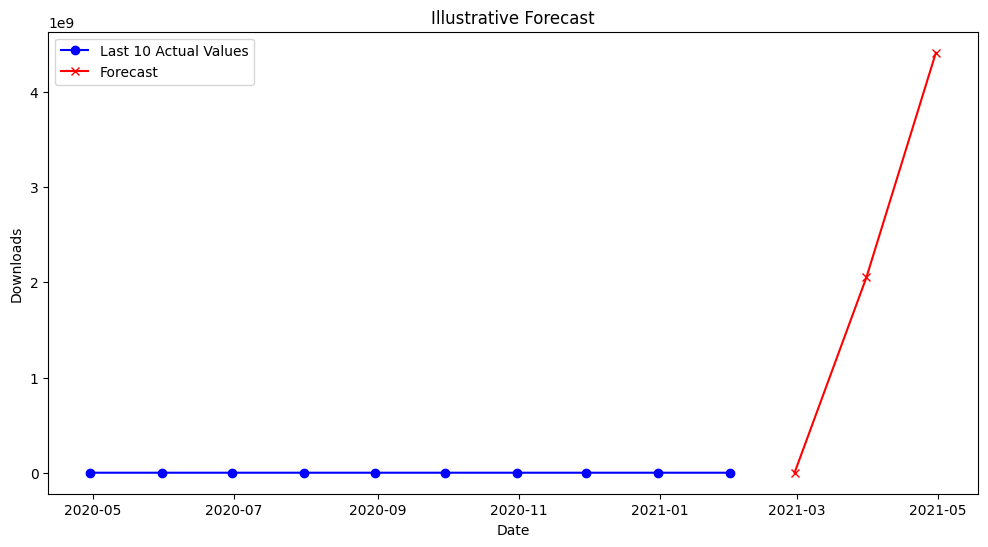

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(time_series_data, label='Original Data', color='blue')
plt.plot(time_series_data[:train_size], y_train_pred, label='Training Predictions', color='green')

# Correct way to get the test index
test_index = time_series_data.index[len(time_series_data) - len(y_test_pred):]
plt.plot(test_index, y_test_pred, label='Test Predictions', color='red')

plt.title('Time Series Forecasting with Linear Regression')
plt.xlabel('Date')
plt.ylabel('Downloads')
plt.legend()
plt.show()

#   - Plot the forecast (illustrative)
plt.figure(figsize=(12, 6))
plt.plot(time_series_data[-10:], label='Last 10 Actual Values', color='blue', marker='o')
forecast_index = pd.date_range(start=time_series_data.index[-1], periods=forecast_steps + 1, freq='M')[1:]
plt.plot(forecast_index, forecast, label='Forecast', color='red', marker='x')
plt.title('Illustrative Forecast')
plt.xlabel('Date')
plt.ylabel('Downloads')
plt.legend()
plt.show()